In [3]:
!pip install sagemaker

In [1]:
import boto3  # conncet for s3 bucket
import sagemaker
import time
from sagemaker.utils import name_from_base

# bucket = "windbucket" # Insert the name of your S3 bucket from CloudFormation outputs
# role = sagemaker.get_execution_role()
sm_boto2 = boto3.client("sagemaker")
sess = sagemaker.Session()
region = sess.boto_session.region_name
prefix = "models/pytorch"
bucket = "windbucket" # Insert the name of your S3 bucket from CloudFormation outputs

assert bucket, "ERROR: Insert the name of your S3 bucket before moving on"

sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\saart\AppData\Local\sagemaker\sagemaker\config.yaml


## Exploratory data analysis

This notebook uses historical data that has been extracted from a SCADA system that exposes telemetry from the wind farm simulator. The data set consists of 10 min averages of measurements taken at each turbine (`turbineX_wind_speed`, `turbineX_wind_direction`, `turbineX_yaw_angle`, `turbineX_power`) and at the control station (`speed` and `direction`). Simulated historical data has already been loaded in this SageMaker environment, and we will start by running an exploratory analysis.

In [8]:
import os
import pandas as pd

FILE_PATH = os.path.join(os.getcwd(), "data", "simulated_data.csv")

df = pd.read_csv(FILE_PATH, index_col="timestamp", parse_dates=[0])
df.head()

,speed,direction,turbine0_wind_speed,turbine0_wind_direction,turbine0_power,turbine0_yaw_angle,turbine1_wind_speed,turbine1_wind_direction,turbine1_power,turbine1_yaw_angle,turbine2_wind_speed,turbine2_wind_direction,turbine2_power,turbine2_yaw_angle,turbine3_wind_speed,turbine3_wind_direction,turbine3_power,turbine3_yaw_angle
timestamp,,,,,,,,,,,,,,,,,,
01-01-2019 00:00,6.00,280.00,5.92,278.96,696.17,5.0,6.01,279.59,700.70,0.1,6.11,279.05,674.41,0.0,6.23,279.95,657.87,0.1
01-01-2019 00:10,5.81,279.29,5.81,279.91,635.64,0.0,5.92,278.26,635.37,0.0,5.99,278.77,574.11,0.0,5.83,278.41,572.25,0.0
01-01-2019 00:20,5.98,279.47,6.00,278.36,694.62,-0.1,5.85,281.05,688.96,5.0,6.01,278.56,638.95,0.0,5.99,280.54,657.97,-0.1
01-01-2019 00:30,6.36,280.21,6.26,281.63,839.43,4.8,6.51,278.94,845.74,0.1,6.47,281.48,818.00,-0.1,6.19,281.51,799.13,-0.1
01-01-2019 00:40,6.44,280.19,6.54,279.96,877.56,0.1,6.31,280.29,877.48,-0.1,6.44,281.68,832.61,0.1,6.56,280.95,831.58,0.0


The first step will be the exploration of the data set in search for insight into the process dynamics. We will start by plotting time series data for wind conditions and power generated by the wind farm.

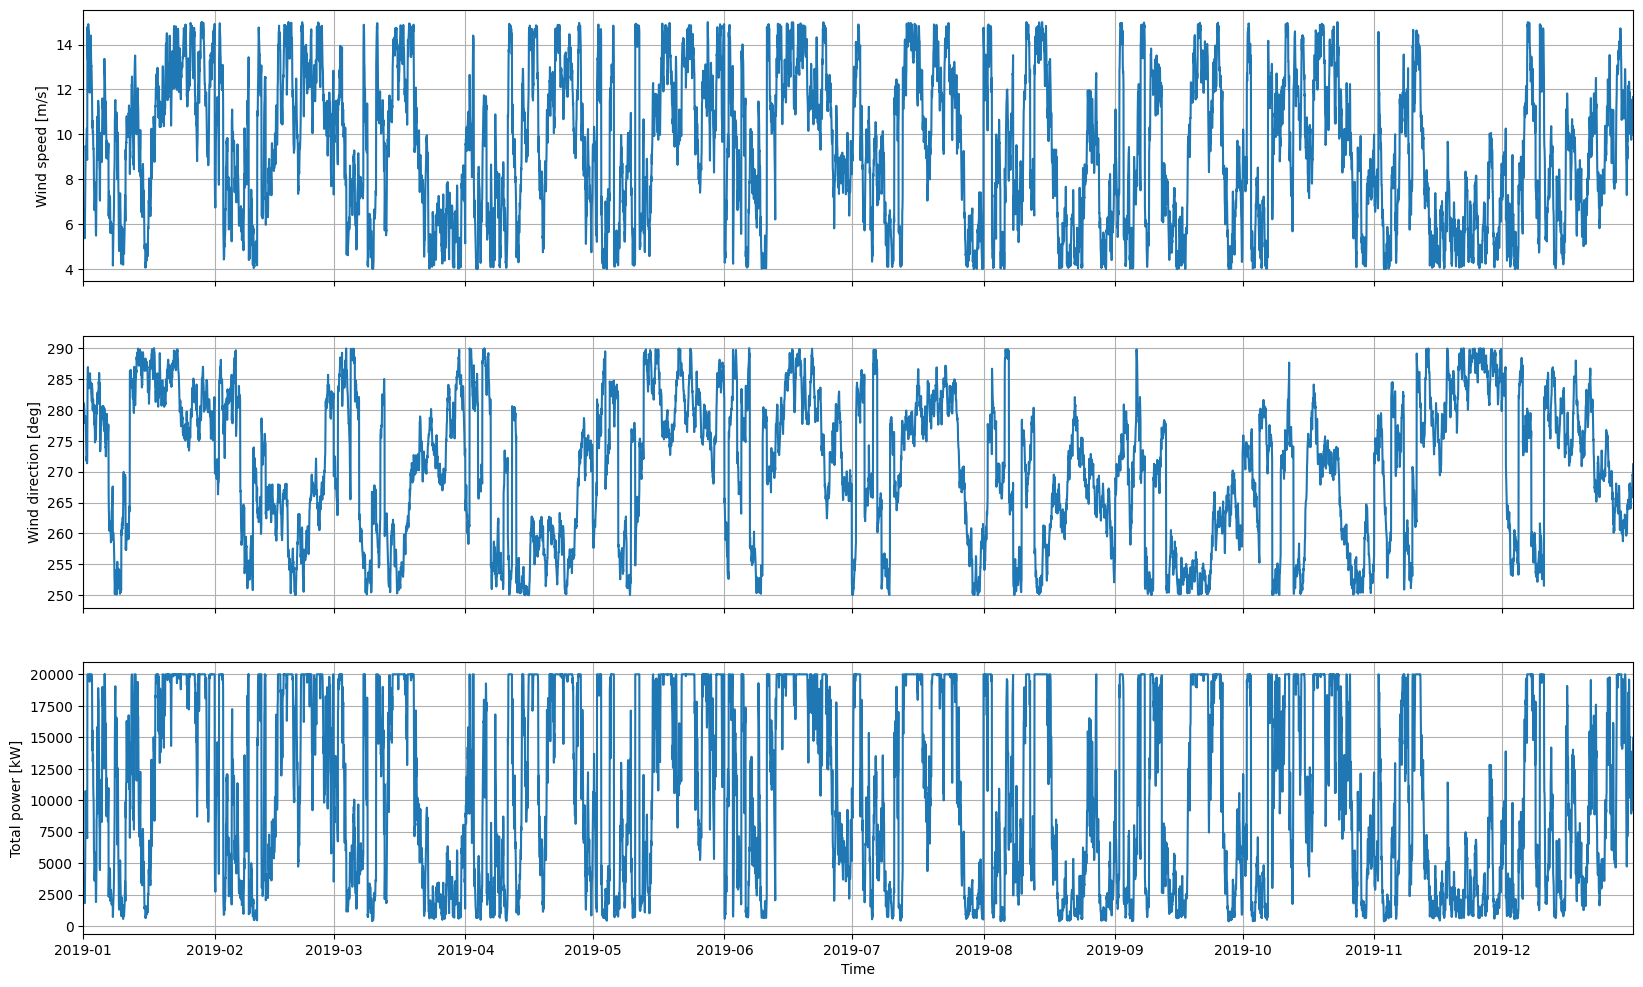

In [3]:
import matplotlib.pyplot as plt

# Exploratory analysis of historical data
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(20,12))

# Subplot 1: Wind speed [m/s]
resampled_speed = df["speed"].resample("1H").mean()
ax1.plot(resampled_speed)
ax1.set_xlim(resampled_speed.index.min(), resampled_speed.index.max())
ax1.set_ylabel("Wind speed [m/s]")
ax1.grid(True)

# Subplot 2: Wind direction [degrees]
resampled_direction = df["direction"].resample("1H").mean()
ax2.plot(resampled_direction)
ax2.set_ylabel("Wind direction [deg]")
ax2.grid(True)

# Subplot 3: Total power generated [kW]
resampled_power = (df["turbine0_power"]+df["turbine1_power"]+df["turbine2_power"]+df["turbine3_power"]).resample("1H").mean()
ax3.plot(resampled_power)
ax3.set_xlabel("Time")
ax3.set_ylabel("Total power [kW]")
ax3.grid(True)

plt.show()

From the plots we can observe that there is a wide range of variation for wind speed, which goes from approximately 4 m/s to 15 m/s, but that wind direction only varies between 250 degrees to 290 degrees.

We can also observe that there appears to be a positive relationship between wind speed and total power, i.e., more power is generated when wind speed is higher.

Now let us plot yaw angles in this one-year period. Yaw angles have been allowed to vary to collect data at various wind conditions and yaw angle configuration (mapping of the operational space). Note that we will only plot yaw angls for `turbine0` and `turbine1` because those are the leading turbines. Wake steering in the trailing turbines will have no effect on power generation.

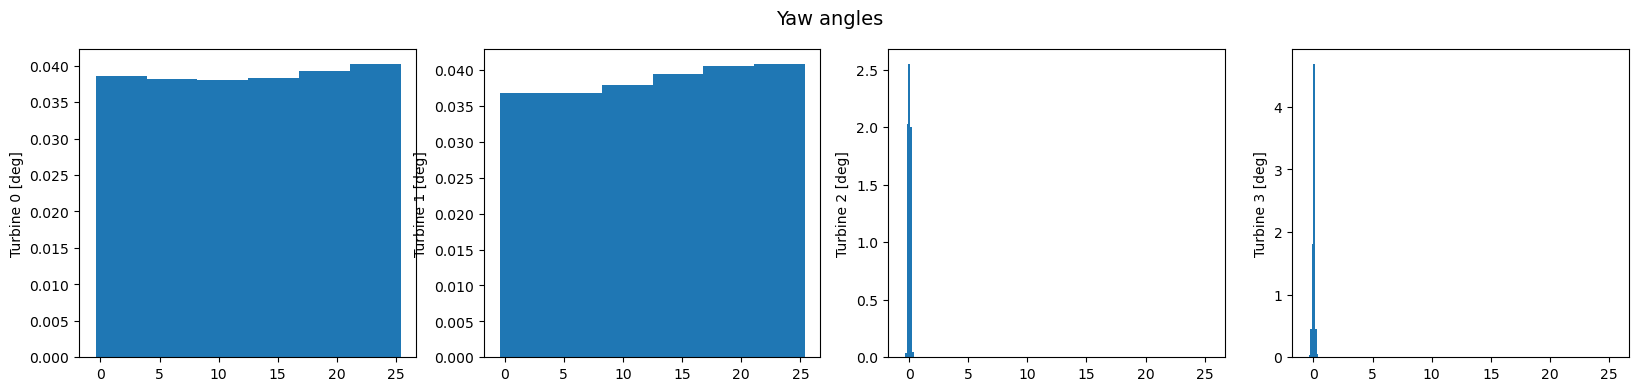

In [9]:
import matplotlib.pyplot as plt

# Explore the effect of yaw angles in cooperative power generation
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharex=True, figsize=(20,4))

# Yaw angles in turbine 0
ax1.hist(df["turbine0_yaw_angle"], bins=6, density=True)
ax1.set_ylabel("Turbine 0 [deg]")

# Yaw angles in turbine 1
ax2.hist(df["turbine1_yaw_angle"], bins=6, density=True)
ax2.set_ylabel("Turbine 1 [deg]")

# Yaw angles in turbine 2
ax3.hist(df["turbine2_yaw_angle"], bins=6, density=True)
ax3.set_ylabel("Turbine 2 [deg]")

# Yaw angles in turbine 3
ax4.hist(df["turbine3_yaw_angle"], bins=6, density=True)
ax4.set_ylabel("Turbine 3 [deg]")

plt.suptitle("Yaw angles", fontsize=14)
plt.show()

There is an even distribution of data points collected for yaw angles that vary between 0 degrees and 25 degrees for turbines 0 and 1. Turbines 2 and 3 (trailing turbines) have not been subjected to wake steering.

Let us have a look at the relationships between power in two turbines (a leading one and a trailing one) and speed. There is a clear positive relationship between wind speed and power -- when there is more wind, turbines generate more power.

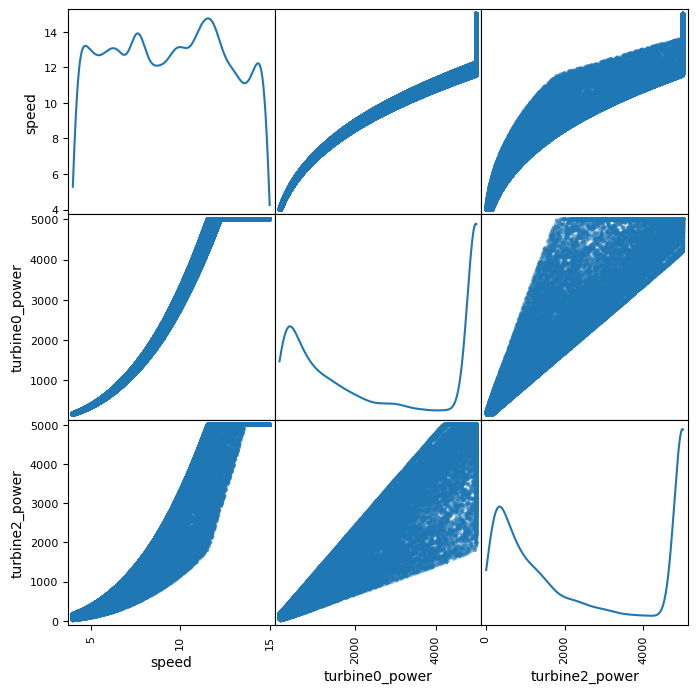

In [10]:
import matplotlib.pyplot as plt

# Plot the dependency between power generated at a leading turbine and a trailing turbine, and speed
pd.plotting.scatter_matrix(df[["speed", "turbine0_power", "turbine2_power"]],
                           figsize=(8,8), diagonal='kde')
plt.show()

Now let us **correct for changes in wind conditions (speed and direction)** and see if there is a relationship between the yaw of a leading turbine and the power generated in the leading turbine and the one downwind.

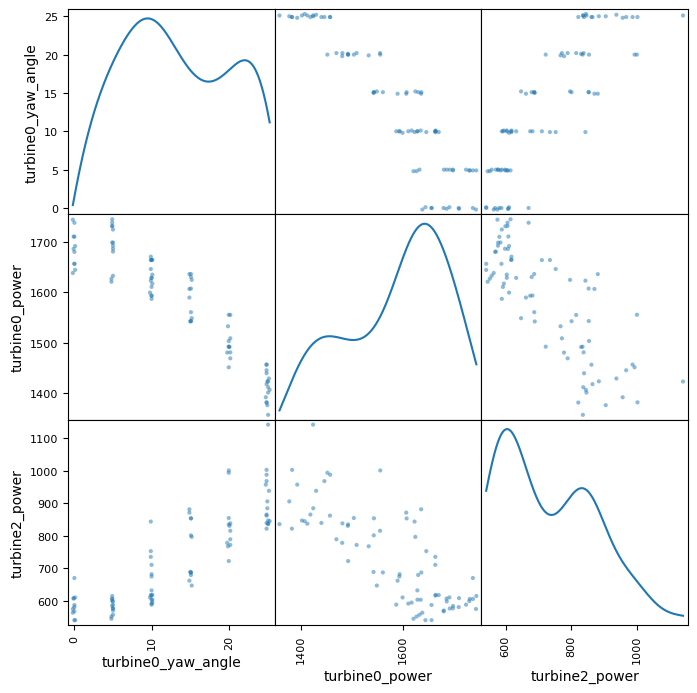

In [11]:
import matplotlib.pyplot as plt

# Select only records when speed is near 8.0 m/s and wind direction is close to 270 degrees
df_ = df[(df["speed"] >= 7.9) & (df["speed"] <= 8.1) &
         (df["direction"] >= 268.0) & (df["direction"] <= 272.0)]

pd.plotting.scatter_matrix(df_[["turbine0_yaw_angle", "turbine0_power", "turbine2_power"]],
                           figsize=(8,8), diagonal='kde')
plt.show()

Now we observe an interesting phenomenon. At low wind speeds, the **intentional misalignment of the yaw in leading turbines decreases the power generated by that turbine but increases the power generated in the trailing turbine**. In subset of data shown above, wake steering can reduce power in turbine 0 (leading) by up to 300 kW while increasing power in turbine 2 (trailing) by up to 400 kW. It is, however, still difficult to predict the effect that wake steering will have on the power generated by the leading and trailing turbines. Machine learning can help with that part.

## Building a power generation model

Historical data will now be used to build a machine learning model of the wind farm dynamics. The following cell shows the script of that defined process model designed in PyTorch, an open source machine learning framework. The model will take four inputs (`speed`, `direction`, `turbine0_yaw_angle` and `turbine1_yaw_angle`) and will return four outputs (`turbine0_power`, `turbine1_power`, `turbine2_power` and `turbine4_power`).

Spend a minute exploring the structure of the multilayer perceptron model that is used to predict the behavior of the yaw angle optimization process.

In [ ]:
!pygmentize WindFarmModel.py

Before training the model, historical data will be split into a training and a validation set, which will have 90% and 10% of the data, respectively.

In [12]:
import numpy as np

model_data = df[["speed", "direction", "turbine0_yaw_angle", "turbine1_yaw_angle",
                 "turbine0_power", "turbine1_power", "turbine2_power", "turbine3_power"]]
train_data, validation_data = np.split(
    model_data.sample(frac=1, random_state=42),
    [int(0.9 * len(model_data))])

C:\Users\saart\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


The `process_dataframe` function scales input and output variables before training the `WindFarmModel` to train the neural network faster and prevent issues with local optima.

In [ ]:
!pip install torchvision 

In [13]:
import torch

def process_dataframe(df):
    """
    Preprocess a pandas dataframe to extract
    independent and depent variables, and scale them
    """
    X = df[['speed', 'direction', 'turbine0_yaw_angle', 'turbine1_yaw_angle']].values
    Y = df[['turbine0_power', 'turbine1_power', 'turbine2_power', 'turbine3_power']].values
    # Scale speed between 4 and 15 (min and max from dataset)
    X[:,0] = (X[:,0]-4.0)/11.0
    # Scale direction between 250 and 290
    X[:,1] = (X[:,1]-250.0)/40.0
    # Scale turbine0_yaw_angle between 0 and 25
    X[:,2] = X[:,2]/25.0
    # Scale turbine1_yaw_angle between 0 and 25
    X[:,3] = X[:,3]/25.0

    # Scale turbine power between 0 and 5 MW (nominal design conditions)
    Y = Y/5000.0
    
    # Convert to PyTorch tensors
    X = torch.from_numpy(X.astype(np.float32))
    Y = torch.from_numpy(Y.astype(np.float32))
    
    return (X, Y)

X_train, Y_train = process_dataframe(train_data)
X_validation, Y_validation = process_dataframe(validation_data)




We will now select a learning rate, a loss function, and an optimizer. In this case we will use the Adam optimizer with a learning rate of 0.005. 

In [15]:
from WindFarmModel import WindFarmModel
import torch.nn as nn

model = WindFarmModel()
learning_rate = 0.005
l = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr =learning_rate)

Model training took 664.7 seconds


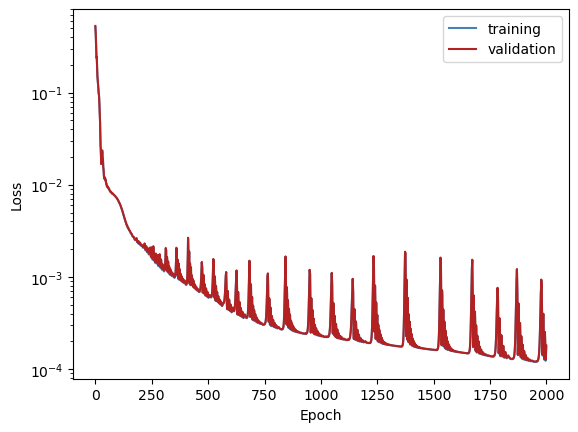

In [16]:
import matplotlib.pyplot as plt
import timeit

num_epochs = 2000
training_loss, validation_loss = [], []

tic=timeit.default_timer()
for epoch in range(num_epochs):
    # Forward feed
    Y_pred = model(X_train.requires_grad_())
    # Calculate the training loss
    t_loss = l(Y_pred, Y_train)
    training_loss.append(t_loss.item())
    # Calculate validation loss
    Y_pred = model(X_validation)
    v_loss = l(Y_pred, Y_validation)
    validation_loss.append(v_loss.item())
    # Backpropagation: calculate gradients
    t_loss.backward()
    # Update the weights
    optimizer.step()
    # Clear out the gradients from the last step loss.backward()
    optimizer.zero_grad()

toc=timeit.default_timer()

print("Model training took {:.1f} seconds".format(toc-tic))

# Plot training and validation losses
plt.plot(training_loss, color="steelblue", label="training")
plt.plot(validation_loss, color="firebrick", label="validation")
plt.xlabel("Epoch")
plt.ylabel("Loss"); plt.yscale('log')
plt.legend()

plt.show()

### Evaluate process model

We now can evaluate the `WindFarmModel` with various conditions (i.e., different combinations of `wind speed` and `wind direction`) and compare them to historical data. Let us evaluate the case we plotted a few cells above (wind speed at 8.0 m/s and wind direction at 270 degrees). We will compare both the aligned and yawed scenarios.

In [17]:
def evaluate_pytorch_model(model, manipulated_vars):
    """
    Return prediction for a set of manipulated variables
    """
    X_test = manipulated_vars[['speed', 'direction', 'turbine0_yaw_angle', 'turbine1_yaw_angle']].values
    X_test[:,0] = (X_test[:,0]-4.0)/11.0
    X_test[:,1] = (X_test[:,1]-250.0)/40.0
    X_test[:,2] = X_test[:,2]/25.0
    X_test[:,3] = X_test[:,3]/25.0
    X_test = torch.from_numpy(X_test.astype(np.float32))
    Y_test = model(X_test.float()).cpu().detach().numpy()
    Y_test = Y_test*5000.0
    prediction = pd.DataFrame({
        "speed": manipulated_vars["speed"].values.round(2),
        "direction": manipulated_vars["direction"].values.round(2),
        "turbine0_yaw_angle": manipulated_vars["turbine0_yaw_angle"].values.round(2),
        "turbine1_yaw_angle": manipulated_vars["turbine1_yaw_angle"].values.round(2),
        "turbine0_power": Y_test[:,0].round(2),
        "turbine1_power": Y_test[:,1].round(2),
        "turbine2_power": Y_test[:,2].round(2),
        "turbine3_power": Y_test[:,3].round(2)
    })
    
    return prediction

In [18]:
# Predict aligned scenario
manipulated_vars = pd.DataFrame({"speed": [8.0], "direction": [270.0],
                                 "turbine0_yaw_angle": [0.0], "turbine1_yaw_angle": [0.0]})

prediction = evaluate_pytorch_model(model, manipulated_vars)
measurements = prediction.loc[0,:]

print("At wind speed {:.2f} m/s at direction {:.0f} with no yaw misalignment".format(
    measurements["speed"], measurements["direction"]))
for ix in range(4):
    print("Turbine {:d} generated {:.2f} kW".format(ix, measurements["turbine{}_power".format(ix)]))

At wind speed 8.00 m/s at direction 270 with no yaw misalignment
Turbine 0 generated 1694.87 kW
Turbine 1 generated 1697.76 kW
Turbine 2 generated 572.58 kW
Turbine 3 generated 553.95 kW


In [19]:
# Predict yawed scenario
manipulated_vars = pd.DataFrame({"speed": [8.0], "direction": [270.0],
                                 "turbine0_yaw_angle": [25.0], "turbine1_yaw_angle": [25.0]})

prediction = evaluate_pytorch_model(model, manipulated_vars)
measurements = prediction.loc[0,:]

print("At wind speed {:.2f} m/s at direction {:.0f} with 25 degree yaw misalignment".format(
    measurements["speed"], measurements["direction"]))
for ix in range(4):
    print("Turbine {:d} generated {:.2f} kW".format(ix, measurements["turbine{}_power".format(ix)]))

At wind speed 8.00 m/s at direction 270 with 25 degree yaw misalignment
Turbine 0 generated 1375.48 kW
Turbine 1 generated 1408.69 kW
Turbine 2 generated 943.00 kW
Turbine 3 generated 991.74 kW


Now we will persist the model so it can be reused without having to retrain the model every time. The model will be put inside a TGZ file and uploaded to an S3 bucket so we can deploy it to the edge device later.

In [20]:
import tarfile
import os

# Trace the whole module (class) and construct a ScriptModule with a single forward method
module = torch.jit.trace(model.float().eval(), torch.rand(1,4).float())
module.save("wind-farm.pth")
model_name = "wind-farm-model"

try:
    os.remove("{:s}.tar.gz".format(model_name))
except:
    pass

with tarfile.open("{:s}.tar.gz".format(model_name), "w:gz") as f:
    f.add("wind-farm.pth")

In [21]:
# Upload to S3
model_path = sess.upload_data(path="{:s}.tar.gz".format(model_name), bucket = bucket, key_prefix=prefix)
model_s3_uri = "s3://{:s}/{:s}/{:s}.tar.gz".format(bucket, prefix, model_name)
print("The model tarball is available at: ", model_s3_uri)

The model tarball is available at:  s3://windbucket/models/pytorch/wind-farm-model.tar.gz


## Process optimization

Now we will use the model to find the optimal yaw misalignment for the leading turbines in the wind farm. We will select yaw angles between 0 and 25 degrees.

In this example we will use the `dual_annealing` function from `scipy` to find optimal yaw angles.

In [22]:
from scipy.optimize import dual_annealing
import pandas as pd
import numpy as np
import timeit

def optimal_manipulated_vars(wind_speed, wind_direction):
    """
    Maximize total generated power
    """
    
    wind_speed = wind_speed
    wind_direction = wind_direction
    # Admissible bounds for manipulated variables
    bounds = ((0.0, 25.0), (0.0, 25.0))
    
    def objective(x):
        '''
        Objective function to maximize: Penalizes deviations from
        wind_speed and wind_direction and turbine power leaving the desired range
        '''
        manipulated_vars = pd.DataFrame({"speed": [wind_speed], "direction": [wind_direction],
                                 "turbine0_yaw_angle": [x[0]], "turbine1_yaw_angle": [x[1]]})
        prediction = evaluate_pytorch_model(model, manipulated_vars)
        cost = -(prediction["turbine0_power"][0]+prediction["turbine1_power"][0]+
                 prediction["turbine2_power"][0]+prediction["turbine3_power"][0])

        return cost
    tic=timeit.default_timer()
    result = dual_annealing(objective, bounds=bounds, maxiter=2000)
    toc=timeit.default_timer()
    
    return (result['x'], result['nfev'], -result['fun'], toc-tic)


The main benefit is that now the user does not need to evaluate multiple what-if scenarios to find the yaw angle misalignment that will maximize power generated. We can run optimization to confirm that a small misalignment in the leading turbines can lead to optimal conditions in the fleet by sacrificing some performance in the leading turbines to increase generation in the trailing turbines (cooperative control).

In [23]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')

# Maximize power generation when speed is 8.0 m/s and the direction is 270 degrees
x, nfev, fev, elapsed_time = optimal_manipulated_vars(8.0, 270.0)

# Summarize the result
print('Total Evaluations: {:d}'.format(nfev))
print("The optimal yaw angle for turbine 0 is {:.2f}".format(x[0]))
print("The optimal yaw angle for turbine 1 is {:.2f}".format(x[1]))
print("The wind farm is predicted to produce {:.1f} kW".format(fev))
print("Optimization took {:.1f} seconds".format(elapsed_time))



Total Evaluations: 8062
The optimal yaw angle for turbine 0 is 17.21
The optimal yaw angle for turbine 1 is 25.00
The wind farm is predicted to produce 4777.4 kW
Optimization took 28.3 seconds
